# Example: Convolutional Neural Network For Image Classification

**Reference Materials:** 
(I strongly suggest all of you should read through these pages)
* https://www.tensorflow.org/versions/r0.10/tutorials/mnist/beginners/index.html
* http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/
* http://colah.github.io/posts/2014-07-Understanding-Convolutions/

## Convolution
### What is Convolution?
The convolution of $f$ and $g$ is defined as:

$(f * g)(t) = \int_{-\infty}^{\infty}f(t-\tau)g(\tau) d\tau$

![](https://upload.wikimedia.org/wikipedia/commons/6/6a/Convolution_of_box_signal_with_itself2.gif)
It can be viewed as the matching similarity between filter $g$ and function $f$

Discrete version:

$(f * g)[n] = \sum_{m=-M}^{M}f(n-m)g(m)$

It's natural to be extended to 2D, and on image, discrete version can be viewed as matrix multiplication

![](http://deeplearning.stanford.edu/wiki/images/6/6c/Convolution_schematic.gif)

### What are convolutional neural networks (CNN)?

CNNs are basically just several layers of convolutions with nonlinear activation functions like ReLU or tanh applied to the results. 

During the training phase, a **CNN automatically learns the values of its filters** based on the task you want to perform. 

![](http://www.wildml.com/wp-content/uploads/2015/11/Screen-Shot-2015-11-07-at-7.26.20-AM.png)

In [12]:
import tensorflow as tf
import numpy as np

### Import MNIST data

In [2]:
# The MNIST database of handwritten digits
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./data/MNIST_data", one_hot=True)

Extracting ./data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST_data/t10k-labels-idx1-ubyte.gz


[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


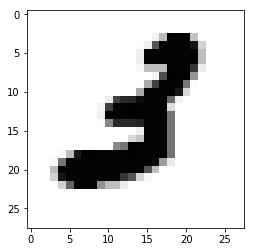

In [11]:
# Show data
import matplotlib.pyplot as plt
%matplotlib inline

i = np.random.randint(len(mnist.train.images))
print( mnist.train.labels[i])
sample_img = mnist.train.images[i]
plt.imshow(sample_img.reshape([28, 28]), cmap='Greys')

## CNN Model

Example code for a two layers *conv-max_pooling* CNN model.

In [14]:
# Parameters
learning_rate = 0.001
training_iters = 200000
batch_size = 128
display_step = 10

# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y,
                                       keep_prob: dropout})
        if step % display_step == 0:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y,
                                                              keep_prob: 1.})
            print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc)
        step += 1
    print "Optimization Finished!"

    # Calculate accuracy for 256 mnist test images
    print "Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: mnist.test.images[:256],
                                      y: mnist.test.labels[:256],
                                      keep_prob: 1.})

Iter 1280, Minibatch Loss= 22268.925781, Training Accuracy= 0.30469
Iter 2560, Minibatch Loss= 7977.673828, Training Accuracy= 0.57031
Iter 3840, Minibatch Loss= 5843.934570, Training Accuracy= 0.64844
Iter 5120, Minibatch Loss= 3626.525391, Training Accuracy= 0.75781
Iter 6400, Minibatch Loss= 3704.707275, Training Accuracy= 0.74219
Iter 7680, Minibatch Loss= 4671.961426, Training Accuracy= 0.72656
Iter 8960, Minibatch Loss= 3131.913574, Training Accuracy= 0.79688
Iter 10240, Minibatch Loss= 2444.571777, Training Accuracy= 0.83594
Iter 11520, Minibatch Loss= 2822.522461, Training Accuracy= 0.83594
Iter 12800, Minibatch Loss= 1918.632080, Training Accuracy= 0.89062
Iter 14080, Minibatch Loss= 1912.581543, Training Accuracy= 0.87500
Iter 15360, Minibatch Loss= 1669.649902, Training Accuracy= 0.90625
Iter 16640, Minibatch Loss= 1893.919189, Training Accuracy= 0.88281
Iter 17920, Minibatch Loss= 1143.653809, Training Accuracy= 0.91406
Iter 19200, Minibatch Loss= 1386.163208, Training Accu